<a href="https://colab.research.google.com/github/steinhaug/stable-diffusion/blob/main/qkimxx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@markdown Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla T4, 15109 MiB, 15109 MiB


https://github.com/ShivamShrirao/diffusers/tree/main/examples/dreambooth

## Install Requirements

In [2]:
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py
%pip install -qq git+https://github.com/ShivamShrirao/diffusers
%pip install -q -U --pre triton
%pip install -q accelerate transformers ftfy bitsandbytes==0.35.0 gradio natsort

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.7/18.7 MB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 89.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 13.

In [3]:
#@title Login to HuggingFace 🤗

#@markdown You need to accept the model license before downloading or using the Stable Diffusion weights. Please, visit the [model card](https://huggingface.co/runwayml/stable-diffusion-v1-5), read the license and tick the checkbox if you agree. You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work.
# https://huggingface.co/settings/tokens
!mkdir -p ~/.huggingface
HUGGINGFACE_TOKEN = "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" #@param {type:"string"}
!echo -n "{HUGGINGFACE_TOKEN}" > ~/.huggingface/token

### Install xformers from precompiled wheel.

In [4]:
%pip install -q https://github.com/brian6091/xformers-wheels/releases/download/0.0.15.dev0%2B4c06c79/xformers-0.0.15.dev0+4c06c79.d20221205-cp38-cp38-linux_x86_64.whl
# These were compiled on Tesla T4.

# If precompiled wheels don't work, install it with the following command. It will take around 40 minutes to compile.
# %pip install git+https://github.com/facebookresearch/xformers@4c06c79#egg=xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 7.5 MB/s eta 0:00:00


## Settings and run

In [5]:
#@markdown If model weights should be saved directly in google drive (takes around 4-5 GB).
save_to_gdrive = True #@param {type:"boolean"}
if save_to_gdrive:
    from google.colab import drive
    drive.mount('/content/drive')

#@markdown Name/Path of the initial model.
MODEL_NAME = "runwayml/stable-diffusion-v1-5" #@param {type:"string"}

#@markdown Enter the directory name to save model at.

OUTPUT_DIR = "stable_diffusion_weights/qkimxx" #@param {type:"string"}
if save_to_gdrive:
    OUTPUT_DIR = "/content/drive/MyDrive/" + OUTPUT_DIR
else:
    OUTPUT_DIR = "/content/" + OUTPUT_DIR

print(f"[*] Weights will be saved at {OUTPUT_DIR}")

!mkdir -p $OUTPUT_DIR

Mounted at /content/drive
[*] Weights will be saved at /content/drive/MyDrive/stable_diffusion_weights/qkimxx


# Start Training

Use the table below to choose the best flags based on your memory and speed requirements. Tested on Tesla T4 GPU.


| `fp16` | `train_batch_size` | `gradient_accumulation_steps` | `gradient_checkpointing` | `use_8bit_adam` | GB VRAM usage | Speed (it/s) |
| ---- | ------------------ | ----------------------------- | ----------------------- | --------------- | ---------- | ------------ |
| fp16 | 1                  | 1                             | TRUE                    | TRUE            | 9.92       | 0.93         |
| no   | 1                  | 1                             | TRUE                    | TRUE            | 10.08      | 0.42         |
| fp16 | 2                  | 1                             | TRUE                    | TRUE            | 10.4       | 0.66         |
| fp16 | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 1.14         |
| no   | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 0.49         |
| fp16 | 1                  | 2                             | TRUE                    | TRUE            | 11.56      | 1            |
| fp16 | 2                  | 1                             | FALSE                   | TRUE            | 13.67      | 0.82         |
| fp16 | 1                  | 2                             | FALSE                   | TRUE            | 13.7       | 0.83          |
| fp16 | 1                  | 1                             | TRUE                    | FALSE           | 15.79      | 0.77         |


Add `--gradient_checkpointing` flag for around 9.92 GB VRAM usage.

remove `--use_8bit_adam` flag for full precision. Requires 15.79 GB with `--gradient_checkpointing` else 17.8 GB.

remove `--train_text_encoder` flag to reduce memory usage further, degrades output quality.

In [6]:
# You can also add multiple concepts here. Try tweaking `--max_train_steps` accordingly.

concepts_list = [
    {
      "instance_prompt": "photo of qkimclooney george clooney",
      "class_prompt": "photo of george clooney",
      "instance_data_dir": "/content/data/qkimclooney",
      "class_data_dir": "/content/data/GeorgeClooney"
    },
    {
      "instance_prompt": "photo of qkimbruce Bruce Willis",
      "class_prompt": "photo of Bruce Willis",
      "instance_data_dir": "/content/data/qkimbruce",
      "class_data_dir": "/content/data/BruceWillis"
    },
    {
      "instance_prompt": "photo of qkimperson person",
      "class_prompt": "photo of a person",
      "instance_data_dir": "/content/data/qkimperson",
      "class_data_dir": "/content/data/person"
    },
    {
      "instance_prompt": "photo of qkimrock Dwayne Johnson",
      "class_prompt": "photo of Dwayne Johnson",
      "instance_data_dir": "/content/data/qkimrock",
      "class_data_dir": "/content/data/DwayneJohnson"
    }
]

# `class_data_dir` contains regularization images
import json
import os
for c in concepts_list:
    os.makedirs(c["instance_data_dir"], exist_ok=True)

with open("concepts_list.json", "w") as f:
    json.dump(concepts_list, f, indent=4)

In [ ]:
#@markdown Upload your images by running this cell.

#@markdown OR

#@markdown You can use the file manager on the left panel to upload (drag and drop) to each `instance_data_dir` (it uploads faster)

import os
from google.colab import files
import shutil

for c in concepts_list:
    print(f"Uploading instance images for `{c['instance_prompt']}`")
    uploaded = files.upload()
    for filename in uploaded.keys():
        dst_path = os.path.join(c['instance_data_dir'], filename)
        shutil.move(filename, dst_path)

In [ ]:
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
  --output_dir=$OUTPUT_DIR \
  --revision="fp16" \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=100 \
  --sample_batch_size=4 \
  --max_train_steps=25000 \
  --save_interval=1000 \
  --save_sample_prompt="photo of mxxstein person" \
  --save_sample_prompt_2= "photo of qkimclooney george clooney" \
  --save_sample_prompt_3= "photo of qkimbruce Bruce Willis" \
  --save_sample_prompt_4= "photo of qkimrock Dwayne Johnson" \
  --n_save_sample=7 \
  --concepts_list="concepts_list.json"

# Reduce the `--save_interval` to lower than `--max_train_steps` to save weights from intermediate steps.
# `--save_sample_prompt` can be same as `--instance_prompt` to generate intermediate samples (saved along with weights in samples directory).

In [8]:
#@markdown Specify the weights directory to use (leave blank for latest)
WEIGHTS_DIR = "/content/drive/MyDrive/stable_diffusion_weights/qkimxx/1600" #@param {type:"string"}
if WEIGHTS_DIR == "":
    from natsort import natsorted
    from glob import glob
    import os
    WEIGHTS_DIR = natsorted(glob(OUTPUT_DIR + os.sep + "*"))[-1]
print(f"[*] WEIGHTS_DIR={WEIGHTS_DIR}")

[*] WEIGHTS_DIR=/content/drive/MyDrive/stable_diffusion_weights/qkimxx/1600


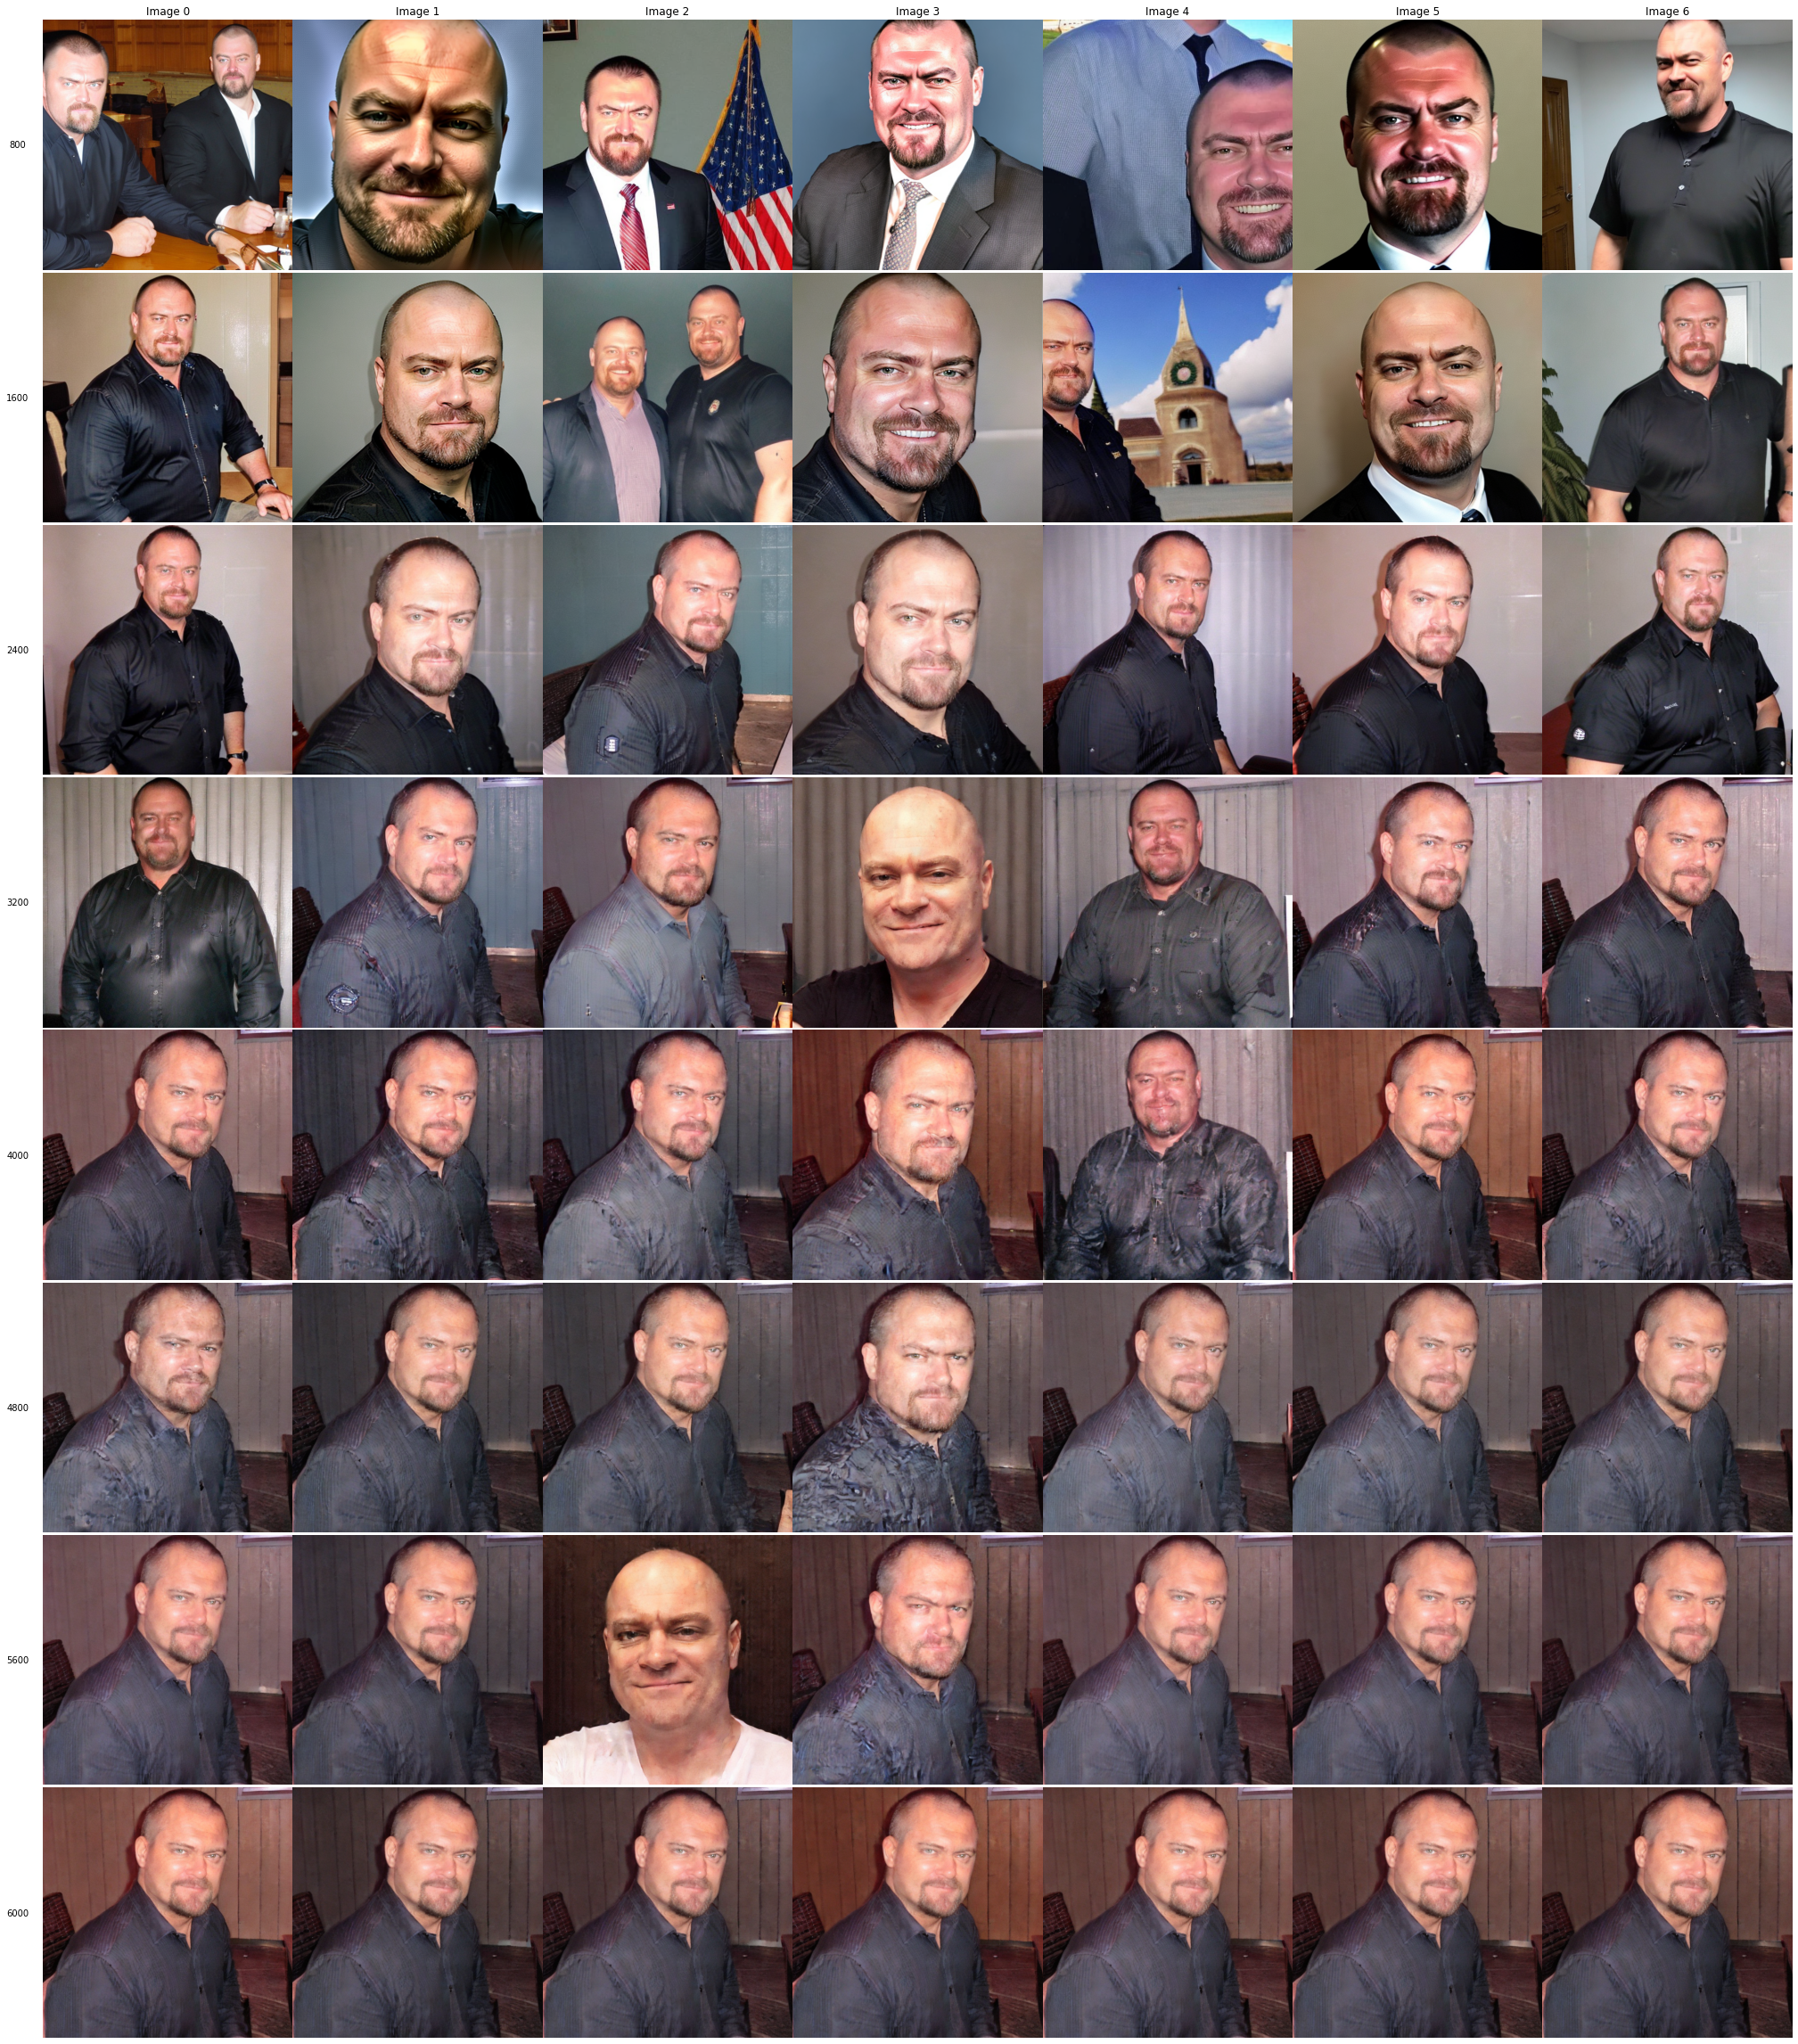

In [11]:
#@markdown Run to generate a grid of preview images from the last saved weights.
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

weights_folder = OUTPUT_DIR
folders = sorted([f for f in os.listdir(weights_folder) if f != "0"], key=lambda x: int(x))

row = len(folders)
col = len(os.listdir(os.path.join(weights_folder, folders[0], "samples")))
scale = 4
fig, axes = plt.subplots(row, col, figsize=(col*scale, row*scale), gridspec_kw={'hspace': 0, 'wspace': 0})

for i, folder in enumerate(folders):
    folder_path = os.path.join(weights_folder, folder)
    image_folder = os.path.join(folder_path, "samples")
    images = [f for f in os.listdir(image_folder)]
    for j, image in enumerate(images):
        if row == 1:
            currAxes = axes[j]
        else:
            currAxes = axes[i, j]
        if i == 0:
            currAxes.set_title(f"Image {j}")
        if j == 0:
            currAxes.text(-0.1, 0.5, folder, rotation=0, va='center', ha='center', transform=currAxes.transAxes)
        image_path = os.path.join(image_folder, image)
        img = mpimg.imread(image_path)
        currAxes.imshow(img, cmap='gray')
        currAxes.axis('off')
        
plt.tight_layout()
plt.savefig('grid.png', dpi=72)

## Convert weights to ckpt to use in web UIs like AUTOMATIC1111.

In [ ]:
#@markdown Run conversion.
ckpt_path = WEIGHTS_DIR + "/model.ckpt"

half_arg = ""
#@markdown  Whether to convert to fp16, takes half the space (2GB).
fp16 = False #@param {type: "boolean"}
if fp16:
    half_arg = "--half"
!python convert_diffusers_to_original_stable_diffusion.py --model_path $WEIGHTS_DIR  --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")

## Inference

In [9]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display, HTML

model_path = WEIGHTS_DIR             # If you want to use previously trained model saved in gdrive, replace this with the full path of model in gdrive

scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
pipe = StableDiffusionPipeline.from_pretrained(model_path, scheduler=scheduler, safety_checker=None, torch_dtype=torch.float16).to("cuda")

g_cuda = None

/usr/local/lib/python3.8/dist-packages/diffusers/utils/deprecation_utils.py:35: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.9.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "steps_offset": 0,
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very nice if you could open a Pull request for the `scheduler/scheduler_config.json` file
  warnings.warn(warning + message, FutureWarning)


In [59]:
#@markdown Can set random seed here for reproducibility.
g_cuda = torch.Generator(device='cuda')
seed = 696969 #@param {type:"number"}
g_cuda.manual_seed(seed)
saved_file_count = 1;

In [ ]:
#@title Run for generating images.

prompt = "qkimperson person as a ninja throwing a ninja star, illustration, highly detailed, digital painting, concept art, masterpiece" #@param {type:"string"}
negative_prompt = "bad anatomy| blurry| fuzzy| extra legs| extra arms| extra fingers| poorly drawn hands| poorly drawn feet| disfigured| out of frame| tiling| bad art| deformed| mutated| double face" #@param {type:"string"}
the_seed = 6912843 #@param {type:"number"}
num_samples = 1 #@param {type:"number"}
guidance_scale = 7.5 #@param {type:"number"}
num_inference_steps = 30 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}


#curSeed = torch.seed()
#print(f"[*] Seed: {curSeed}")
g_cuda = torch.Generator(device='cuda')
g_cuda.manual_seed(the_seed)

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for img in images:
    display(img)
        

In [ ]:
#@title Run for batch creation of images
import os.path
from os import path
from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

model_trained_steps_for_filename = '1600' #@param {type:"string"}
num_samples = 10 #@param {type:"number"}
height = 1024 #@param {type:"number"}
width = 1024 #@param {type:"number"}
images_savepath = '/content/drive/MyDrive/render-1024' #@param {type:"string"}
models = "('KistaP','qkimperson person')" #@param {type:"string"}
models_ = "('KistaP','qkimperson person'),('KistaDJ','qkimrock Dwayne Johnson'),('KistaGC','qkimclooney george clooney'),('KistaBW','qkimbruce Bruce Willis')" #@param {type:"string"}
#@markdown Syntax: ('reference name', 'trained instance name')

kista_trainednames = literal_eval('[' + models + ']')
#kista_trainednames = [('KistaP','qkimperson person'),('KistaDJ','qkimrock Dwayne Johnson'),('KistaGC','qkimclooney george clooney'),('KistaBW','qkimbruce Bruce Willis')]

if path.exists(images_savepath) == False:
  os.mkdir(images_savepath)

auto_prompts = [
  ("warrior_poster",
  696969,7.5,50,
  "poster of __token__, warrior goddess| standing alone on hill| centered| detailed gorgeous face| anime style| key visual| intricate detail| highly detailed| breathtaking| vibrant| panoramic| cinematic| Carne Griffiths| Conrad Roset| Makoto Shinkai",
  "no words| watermark| bad anatomy| blurry| fuzzy| extra legs| extra arms| extra fingers| poorly drawn hands| poorly drawn feet| disfigured| out of frame| tiling| bad art| deformed| mutated| double face"
  ),
  ("halloween_man_1",
  2971107907,7.5,50,
  "The personification of the Halloween holiday played by __token__, portraited as a little girl with short hair and a villain's smile, cute hats, cute cheeks, unreal engine, highly detailed, artgerm digital illustration, woo tooth, studio ghibli, deviantart, sharp focus, artstation, by Alexei Vinogradov bakery, sweets, emerald eyes",
  "bad anatomy, extra legs, extra arms, poorly drawn face, poorly drawn hands, poorly drawn feet, fat, disfigured, out of frame, long neck, poo art, bad hands, bad art, deformed, gun, double head, flowers,asian,hyperrealistic,child",
  ),
  ("halloween_man_2",
  2971107907,7.5,50,
  "The personification of the Halloween holiday in the form of __token__ as a cute girl with short hair and a villain's smile, cute hats, cute cheeks, unreal engine, highly detailed, artgerm digital illustration, woo tooth, studio ghibli, deviantart, sharp focus, artstation, by Alexei Vinogradov bakery, sweets, emerald eyes",
  "bad anatomy, extra legs, extra arms, poorly drawn face, poorly drawn hands, poorly drawn feet, fat, disfigured, out of frame, long neck, poo art, bad hands, bad art, deformed, gun, double head, flowers,asian,hyperrealistic,child",
  ),
  ("warrior",
  16,7.5,50,
  "__token__ as strong warrior princess| centered| key visual| intricate| highly detailed| breathtaking beauty| precise lineart| vibrant| comprehensive cinematic| Carne Griffiths| Conrad Roset",
  "bad anatomy, extra legs, extra arms, poorly drawn face, poorly drawn hands, poorly drawn feet, fat, disfigured, out of frame, long neck, poo art, bad hands, bad art, deformed, gun, double head, flowers,asian,hyperrealistic,child",
  ),
  ("warrior_sketch",
  16,7.5,50,
  "__token__ as strong warrior king| centered| key visual| intricate| highly detailed| breathtaking beauty| precise lineart| vibrant| comprehensive cinematic| Carne Griffiths| Conrad Roset",
  ""
  ),
  ("punk_face",
  422313768,7.5,50,
  "detailed bladerunner portrait of Punk __token__, standing hair line Sheen Holographic Futuristic sci-fi fashion cyberpunk, (neotokyo), synthwave, (aesthetics), futuristic, art by greg rutkowski Alexandros Pyromallis Nekro Rene Margitte illustrated Perfect face, fine details, realistic shaded",
  ""
  ),
  ("Glamor_look",
  1654522787,7.5,50,
  "qkimperson person, wearing a white silk shirt, detailed face, gorgeous, amazing, muscular, fit, medium shot, illustration, concept art, EF 70mm|concept art|Duy Huynh",
  "no words| watermark| bad anatomy| blurry| fuzzy| extra legs| extra arms| extra fingers| poorly drawn hands| poorly drawn feet| disfigured| out of frame| tiling| bad art| deformed| mutated| double face"
  ),
  ("Cyberpunked_1",
  1654522787,7.5,50,
  "qkimperson person, cyberpunk, in heavy raining futuristic tokyo rooftop cyberpunk night, sci-fi, fantasy, intricate, very very beautiful, elegant, neon light, highly detailed, digital painting, artstation, concept art, soft light, hdri, smooth, sharp focus, illustration, art by tian zi and craig mullins and wlop and alphonse much",
  "no words| watermark| bad anatomy| blurry| fuzzy| extra legs| extra arms| extra fingers| poorly drawn hands| poorly drawn feet| disfigured| out of frame| tiling| bad art| deformed| mutated| double face"
  ),
  ("Cyberpunked_2",
  1654522787,7.5,50,
  "qkimperson person, cyberpunk, in heavy raining futuristic tokyo rooftop cyberpunk night, sci-fi, fantasy, intricate, very very beautiful, elegant, neon light, highly detailed, digital painting, artstation, concept art, soft light, hdri, smooth, sharp focus, illustration, art by tian zi and craig mullins and wlop and alphonse much",
  "((missing arms)), ((missing legs)), (((extra arms))), (((extra legs))), (fused fingers), (too many fingers), (((long neck)))"
  ),
  ("Sango_dream_1",
  428858956,7.5,50,
  "qkimperson person, sango fantasy, fantasy magic, , intricate, sharp focus, illustration, highly detailed, digital painting, concept art, matte, Artgerm and Paul lewin and kehinde wiley, masterpiece",
  "no words| watermark| bad anatomy| blurry| fuzzy| extra legs| extra arms| extra fingers| poorly drawn hands| poorly drawn feet| disfigured| out of frame| tiling| bad art| deformed| mutated| double face"
  ),
  ("Sango_dream_2",
  4289232563,7.5,50,
  "qkimperson person,  sango fantasy, fantasy magic, , intricate, sharp focus, illustration, highly detailed, digital painting, concept art, matte, Artgerm and Paul lewin and kehinde wiley, masterpiece",
  "circles, bad anatomy| blurry| fuzzy| extra legs| extra arms| extra fingers| poorly drawn hands| poorly drawn feet| disfigured| out of frame| tiling| bad art| deformed| mutated| double face"
  ),
  ("Fat_rider",
  6912843,7.5,50,
  "qkimperson person as a ninja throwing a ninja star, illustration, highly detailed, digital painting, concept art, masterpiece",
  "bad anatomy| blurry| fuzzy| extra legs| extra arms| extra fingers| poorly drawn hands| poorly drawn feet| disfigured| out of frame| tiling| bad art| deformed| mutated| double face"
  ),
]






for prompt_ref,seed,guidance_scale,num_inference_steps,prompt,negative_prompt in auto_prompts:
    for modelref,kista_modelname in kista_trainednames:
        newprompt = prompt.replace("__token__", kista_modelname)
        g_cuda = torch.Generator(device='cuda')
        g_cuda.manual_seed(seed)
        #print(f"[*] Token: {kista_modelname}, seed: {seed}")
        #print(f"[*] Prompt: {newprompt}")

        with autocast("cuda"), torch.inference_mode():
            images = pipe(
                newprompt,
                height=height,
                width=width,
                negative_prompt=negative_prompt,
                num_images_per_prompt=num_samples,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                generator=g_cuda
            ).images

        image_filenames = []

        for img in images:
            prefix_count = f'{saved_file_count:05d}' + '_'
            outfilename = prefix_count + modelref + '_' + prompt_ref + '_' + model_trained_steps_for_filename
            image_filename = outfilename.replace(" ", '_') + '.png'
            print(f"[*] Saved: {image_filename}")
            img.save(images_savepath + "/" + image_filename)
            image_filenames.append(image_filename)
            #display(img.resize((256, 256)))
            #display(img.resize((128, 128)))
            saved_file_count += 1

        image_folder = images_savepath + '/'
        grid_row = 1
        grid_col = len(image_filenames)
        grid_scale = 2
        fig, axes = plt.subplots(grid_row, grid_col, figsize=(grid_col*grid_scale, grid_row*grid_scale), gridspec_kw={'hspace': 0, 'wspace': 0})
        for j, image_filename in enumerate(image_filenames):
            currAxes = axes[j]
            currAxes.set_title(f"{image_filename[0:5]}")
            image_full_path = os.path.join(image_folder, image_filename)
            imgdata = mpimg.imread(image_full_path)
            currAxes.imshow(imgdata, cmap='gray')
            currAxes.axis('off')
        plt.tight_layout()
        plt.savefig('grid.png', dpi=72)
        plt.show()


  0%|          | 0/50 [00:00<?, ?it/s]

In [99]:
from ast import literal_eval
models = "('KistaP','qkimperson person'),('KistaDJ','qkimrock Dwayne Johnson'),('KistaGC','qkimclooney george clooney'),('KistaBW','qkimbruce Bruce Willis')" #@param {type:"string"}
kista_trainednames = literal_eval('[' + models + ']')

for modelref,kista_modelname in kista_trainednames:
  print (modelref)

KistaP
KistaDJ
KistaGC
KistaBW


In [ ]:
#@markdown Run Gradio UI for generating images.
import gradio as gr

def inference(prompt, negative_prompt, num_samples, height=512, width=512, num_inference_steps=50, guidance_scale=7.5):
    with torch.autocast("cuda"), torch.inference_mode():
        return pipe(
                prompt, height=int(height), width=int(width),
                negative_prompt=negative_prompt,
                num_images_per_prompt=int(num_samples),
                num_inference_steps=int(num_inference_steps), guidance_scale=guidance_scale,
                generator=g_cuda
            ).images

with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            prompt = gr.Textbox(label="Prompt", value="photo of zwx dog in a bucket")
            negative_prompt = gr.Textbox(label="Negative Prompt", value="")
            run = gr.Button(value="Generate")
            with gr.Row():
                num_samples = gr.Number(label="Number of Samples", value=4)
                guidance_scale = gr.Number(label="Guidance Scale", value=7.5)
            with gr.Row():
                height = gr.Number(label="Height", value=512)
                width = gr.Number(label="Width", value=512)
            num_inference_steps = gr.Slider(label="Steps", value=50)
        with gr.Column():
            gallery = gr.Gallery()

    run.click(inference, inputs=[prompt, negative_prompt, num_samples, height, width, num_inference_steps, guidance_scale], outputs=gallery)

demo.launch(debug=True)

In [ ]:
#@title (Optional) Delete diffuser and old weights and only keep the ckpt to free up drive space.

#@markdown [ ! ] Caution, Only execute if you are sure u want to delete the diffuser format weights and only use the ckpt.
import shutil
from glob import glob
import os
for f in glob(OUTPUT_DIR+os.sep+"*"):
    if f != WEIGHTS_DIR:
        shutil.rmtree(f)
        print("Deleted", f)
for f in glob(WEIGHTS_DIR+"/*"):
    if not f.endswith(".ckpt") or not f.endswith(".json"):
        try:
            shutil.rmtree(f)
        except NotADirectoryError:
            continue
        print("Deleted", f)

In [ ]:
#@title Free runtime memory
exit()